In [18]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, Matern
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore GPR convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


class LCSTPredictor:
    def __init__(self):
        self.gpr = None
        self.X = None
        self.y = None
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()


    def create_model(self):
        """Create and initialize the GPR model with standardized data"""
        kernel = ConstantKernel(1.0) * Matern(length_scale=[0.5, 1.0], nu=1) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-12, 1e1))
        self.gpr = GaussianProcessRegressor(
            kernel=kernel,
            n_restarts_optimizer=100,
            random_state=42,
        )
        return self.gpr

    def prepare_data(self, file_path='30/Dataset_2salts.xlsx'):
        """
        Prepare the LCST dataset from Excel file
        Handles multiple LCST measurements and calculates mean and std
        """
        # Read Excel file
        df = pd.read_excel(file_path)

        # Calculate mean LCST and std for each condition
        df['LCST_mean'] = df[['LCST_1', 'LCST_2', 'LCST_3']].mean(axis=1)
        df['LCST_std'] = df[['LCST_1', 'LCST_2', 'LCST_3']].std(axis=1)

        # Replace NaN std with 0.3 as specified
        df['LCST_std'] = df['LCST_std'].fillna(0.3)

        # Store original data for reference
        self.original_data = df

        # Store original data in class variables
        self.X_orig = df[['NaCl', 'NaBr']].values
        self.y_orig = df['LCST_mean'].values
        self.lcst_std_orig = df['LCST_std'].values

        # Prepare X (features) and y (target)
        X = df[['NaCl', 'NaBr']].values
        y = df['LCST_mean'].values

        # Standardize X and y
        self.X = self.X_scaler.fit_transform(X)
        self.y = self.y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

        return self.X, self.y, df['LCST_std'].values

    def leave_one_out_cv(self):
        """Perform leave-one-out cross-validation and create parity plot"""
        if self.X_orig is None or self.y_orig is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")

        # Apply plotting style
        self.set_plotting_parameters()

        loo = LeaveOneOut()
        y_pred_all = []
        y_std_all = []

        for train_idx, test_idx in loo.split(self.X_orig):
            # Split data
            X_train, X_test = self.X_orig[train_idx], self.X_orig[test_idx]
            y_train, y_test = self.y_orig[train_idx], self.y_orig[test_idx]

            # Scale features and target within fold to prevent data leakage
            X_scaler = StandardScaler().fit(X_train)
            y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))

            X_train_scaled = X_scaler.transform(X_train)
            X_test_scaled = X_scaler.transform(X_test)
            y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).ravel()

            # Train and predict
            model = self.create_model()
            model.fit(X_train_scaled, y_train_scaled)
            y_pred, y_std = model.predict(X_test_scaled, return_std=True)

            # Transform predictions back to original scale
            y_pred_orig = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
            y_std_orig = y_std * y_scaler.scale_

            y_pred_all.append(y_pred_orig[0])
            y_std_all.append(y_std_orig[0])

        # Convert to numpy arrays
        y_pred_all = np.array(y_pred_all)
        y_std_all = np.array(y_std_all)

        # Calculate metrics
        r2 = r2_score(self.y_orig, y_pred_all)
        mae = mean_absolute_error(self.y_orig, y_pred_all)
        rmse = np.sqrt(mean_squared_error(self.y_orig, y_pred_all))

        # Create parity plot as a separate figure
        plt.figure(figsize=(6, 6))

        # Plot diagonal line
        min_val = min(self.y_orig.min(), y_pred_all.min()) - 1
        max_val = max(self.y_orig.max(), y_pred_all.max()) + 1
        plt.plot([min_val, max_val], [min_val, max_val], '--', color='grey', label='Perfect prediction')

        # Plot predictions with error bars
        plt.errorbar(self.y_orig, y_pred_all,
                    xerr=self.lcst_std_orig,
                    yerr=y_std_all,
                    fmt='o', color='blue', markersize=8,
                    capsize=5, label='Predictions')

        plt.xlabel('Experimental LCST (°C)')
        plt.ylabel('Predicted LCST (°C)')
        # plt.title('Parity Plot - Leave-One-Out Cross-Validation')
        plt.legend()
        plt.grid(False)

        # Add metrics to the plot
        # metrics_text = f'R² = {r2:.3f}\nMAE = {mae:.2f}°C\nRMSE = {rmse:.2f}°C'
        # plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
        #         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.tight_layout()
        plt.savefig('lcst_parity_plot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Fit final model on all data
        self.X_scaler = StandardScaler().fit(self.X_orig)
        self.y_scaler = StandardScaler().fit(self.y_orig.reshape(-1, 1))

        X_scaled = self.X_scaler.transform(self.X_orig)
        y_scaled = self.y_scaler.transform(self.y_orig.reshape(-1, 1)).ravel()

        self.gpr = self.create_model()
        self.gpr.fit(X_scaled, y_scaled)

        return r2, mae, rmse

    def set_plotting_parameters(self):
        """Set the plotting parameters according to the specified protocol"""
        plt.rcParams['figure.figsize'] = [6, 4]
        plt.rcParams['axes.labelweight'] = 'bold'
        plt.rcParams['font.size'] = 15
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.major.width'] = 1
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['xtick.minor.width'] = 1
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.major.width'] = 1
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['ytick.minor.width'] = 1
        plt.rcParams['xtick.labelsize'] = 16
        plt.rcParams['ytick.labelsize'] = 16
        plt.rcParams['legend.fontsize'] = 16
        plt.rcParams['legend.title_fontsize'] = 16
        plt.rcParams['axes.labelsize'] = 16
        plt.rcParams['axes.titlesize'] = 16
        plt.rcParams['axes.linewidth'] = 1
        plt.rcParams['grid.linewidth'] = 1
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['figure.titlesize'] = 20
        plt.rcParams['font.family'] = 'Arial'

    def _compute_ei(self, X_candidates_std, target_lcst_norm):
        """
        Compute the Expected Improvement (EI) for a set of candidate points.
        EI is defined based on minimizing |pred - target|.
        """
        # Predict mean and std
        y_pred, y_std = self.gpr.predict(X_candidates_std, return_std=True)

        # Improvement is based on negative absolute difference (since we want to minimize |pred - target|)
        diff = np.abs(y_pred - target_lcst_norm)
        improvement = -diff

        # Compute EI
        # EI = improvement * Φ(z) + σ * φ(z), where z = improvement/σ
        # Handle zero std to avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            z = np.divide(improvement, y_std, out=np.zeros_like(improvement), where=y_std>1e-12)
        ei = improvement * norm.cdf(z) + y_std * norm.pdf(z)
        return ei, y_pred, y_std

    def plot_expected_improvement(self, target_lcst):
        if self.gpr is None:
            raise ValueError("Model not trained. Train the model first.")

        # Create a grid of points in original scale
        x_range = np.linspace(0, 1.2, 200)
        y_range = np.linspace(0, 1.2, 200)
        x_grid, y_grid = np.meshgrid(x_range, y_range)
        X_grid = np.column_stack((x_grid.ravel(), y_grid.ravel()))
        X_grid_std = self.X_scaler.transform(X_grid)

        # Get normalized target LCST
        target_lcst_norm = self.y_scaler.transform([[target_lcst]])[0]

        # Compute EI
        ei, y_pred, y_std = self._compute_ei(X_grid_std, target_lcst_norm)
        ei = ei.reshape(x_grid.shape)
        y_pred = self.y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel().reshape(x_grid.shape)
        y_std = y_std * self.y_scaler.scale_
        y_std = y_std.reshape(x_grid.shape)

        # Find maximum EI point
        max_ei_idx = np.unravel_index(np.argmax(ei), ei.shape)
        max_ei_point = (x_grid[max_ei_idx], y_grid[max_ei_idx])
        max_ei_value = ei[max_ei_idx]

        # Predicted LCST at max EI point
        max_ei_point_std = self.X_scaler.transform([[max_ei_point[0], max_ei_point[1]]])
        pred_lcst_at_max, std_at_max = self.gpr.predict(max_ei_point_std, return_std=True)
        pred_lcst_at_max = self.y_scaler.inverse_transform(pred_lcst_at_max.reshape(-1, 1))[0][0]
        score_at_max_ei = abs(pred_lcst_at_max - target_lcst)

        # Get original scale data points
        X_orig = self.X_scaler.inverse_transform(self.X)
        y_orig = self.y_scaler.inverse_transform(self.y.reshape(-1, 1)).ravel()

        # 1. LCST Prediction - create a new figure
        self.set_plotting_parameters()
        plt.figure()  # Use default size from set_plotting_parameters

        # Plot LCST prediction contour
        pred_contour = plt.contourf(x_grid, y_grid, y_pred,
                                   levels=20, cmap='viridis')
        exp_handle = plt.scatter(X_orig[:,0], X_orig[:,1],c='red', marker='o', s=100,label='Experimental Data')

        # Plot target LCST contour
        target_contour = plt.contour(x_grid, y_grid, y_pred,
                                    levels=[target_lcst],
                                    colors='red', linewidths=2)
        plt.clabel(target_contour, inline=True, fontsize=12, fmt=f'{target_lcst}°C')

        star_handle = mlines.Line2D([], [], color='yellow', marker='*', markeredgecolor='black',markersize=10, linestyle='None')
        x_handle = mlines.Line2D([], [], color='yellow', marker='X', markeredgecolor='black',markersize=10, linestyle='None')

        # Combine them into a tuple
        combined_handles = (star_handle, x_handle)

        # --- Add a single legend entry with both markers ---
        plt.legend(handles=[exp_handle, combined_handles],labels=['Experimental Data'],handler_map={tuple: HandlerTuple(ndivide=None)})

        plt.xlabel('NaCl (mol/L)')
        plt.ylabel('NaBr (mol/L)')
        plt.title('LCST Prediction Map')
        plt.grid(True, alpha=0.3)

        # Add colorbar
        colorbar = plt.colorbar(pred_contour)
        colorbar.set_label('LCST (°C)', rotation=90)

        # plt.legend()
        plt.tight_layout()
        plt.show()

        # 2. Uncertainty - create a new figure
        self.set_plotting_parameters()
        plt.figure()  # Use default size from set_plotting_parameters

        # Plot uncertainty contour
        std_contour = plt.contourf(x_grid, y_grid, y_std,
                                  levels=20, cmap='Reds')

        # Plot experimental points
        plt.scatter(X_orig[:,0], X_orig[:,1],
                   c='blue', marker='o', s=100,
                   label='Experimental Data')

        plt.xlabel('NaCl (mol/L)')
        plt.ylabel('NaBr (mol/L)')
        plt.title('Prediction Uncertainty Map')
        plt.grid(True, alpha=0.3)

        # Add colorbar
        colorbar = plt.colorbar(std_contour)
        colorbar.set_label('Uncertainty (°C)', rotation=90)

        plt.legend()
        plt.tight_layout()
        plt.show()

        # 3. Expected Improvement - create a new figure
        self.set_plotting_parameters()
        plt.figure()  # Use default size from set_plotting_parameters

        # Plot EI contour
        ei_contour = plt.contourf(x_grid, y_grid, ei,
                                 levels=20, cmap='plasma')

        # Plot experimental points
        plt.scatter(X_orig[:,0], X_orig[:,1],
                   c='red', marker='o', s=100, edgecolors='red',
                   label='Experimental Data')


        plt.xlabel('NaCl (mol/L)')
        plt.ylabel('NaBr (mol/L)')
        plt.title(f'EI (Target LCST: {target_lcst}°C)')
        plt.grid(True, alpha=0.3)

        # Add colorbar
        colorbar = plt.colorbar(ei_contour)
        colorbar.set_label('Expected Improvement', rotation=90)

        # plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

        return max_ei_point, score_at_max_ei

    def optimize_concentrations(self, target_lcst, method='scipy'):

        if self.gpr is None:
            raise ValueError("Model not trained. Train the model first.")

    # Normalize target LCST
        target_lcst_norm = self.y_scaler.transform([[target_lcst]])[0]

        if method == 'scipy':
            def objective(x_norm):
                x_norm = np.asarray(x_norm).reshape(1, -1)
                pred, _ = self.gpr.predict(x_norm, return_std=True)
                difference = np.abs(pred[0] - target_lcst_norm)
                return float(difference.item())

        # Multiple starting points for optimization
            best_result = None
            best_score = float('inf')
            bounds = [(0, 1), (0, 1)]  # Normalized bounds

            for start_point in [(0,0), (0.5,0.5), (1,1)]:
                result = minimize(
                    objective,
                    x0=start_point,
                    bounds=bounds,
                    method='L-BFGS-B'
                )

                if result.fun < best_score:
                    best_score = result.fun
                    best_result = result

        # Transform results back to original scale
            optimal_concentrations = self.X_scaler.inverse_transform(best_result.x.reshape(1, -1))[0]
            return optimal_concentrations, best_score

        elif method == 'ei':

            x_range = np.linspace(0, 1.2, 200)
            y_range = np.linspace(0, 1.2, 200)
            x_grid, y_grid = np.meshgrid(x_range, y_range)

        # Transform to standardized space for prediction
            X_grid = np.column_stack((x_grid.ravel(), y_grid.ravel()))
            X_grid_std = self.X_scaler.transform(X_grid)

        # Calculate predicted values and uncertainties
            y_pred, y_std = self.gpr.predict(X_grid_std, return_std=True)

        # Calculate improvement (negative because we want to minimize |pred - target|)
            diff = np.abs(y_pred - target_lcst_norm)
            improvement = -diff

        # Calculate Expected Improvement
            z = improvement / y_std
            ei = (improvement * norm.cdf(z) + y_std * norm.pdf(z)).reshape(x_grid.shape)

        # Find the point of maximum EI
            max_ei_idx = np.unravel_index(np.argmax(ei), ei.shape)
            max_ei_point = (x_grid[max_ei_idx], y_grid[max_ei_idx])

        # Calculate the score at the maximum EI point
            max_ei_point_std = self.X_scaler.transform([[max_ei_point[0], max_ei_point[1]]])
            pred_lcst_at_max, _ = self.gpr.predict(max_ei_point_std, return_std=True)
            pred_lcst_at_max = self.y_scaler.inverse_transform(pred_lcst_at_max.reshape(-1, 1))[0][0]
            score_at_max_ei = abs(pred_lcst_at_max - target_lcst)

            return np.array(max_ei_point), score_at_max_ei

        else:
            raise ValueError("Method must be either 'scipy' or 'ei'")

    def visualize_optimization_results(self, target_lcst, optimal_conc_scipy, optimal_conc_ei):
        """Visualize optimization results with all methods in separate plots"""
        if self.gpr is None:
            raise ValueError("Model not trained. Train the model first.")

        # Apply plotting style
        self.set_plotting_parameters()

        # Create a grid of points in original scale
        x_range = np.linspace(0, 1.2, 200)
        y_range = np.linspace(0, 1.2, 200)
        x_grid, y_grid = np.meshgrid(x_range, y_range)
        X_grid = np.column_stack((x_grid.ravel(), y_grid.ravel()))
        X_grid_std = self.X_scaler.transform(X_grid)

        # Make predictions
        y_pred_std, y_std = self.gpr.predict(X_grid_std, return_std=True)
        y_pred = self.y_scaler.inverse_transform(y_pred_std.reshape(-1, 1)).ravel()
        y_pred = y_pred.reshape(x_grid.shape)

        # Create a new figure
        plt.figure()  # Use default size from set_plotting_parameters

        # Plot LCST contour
        contour = plt.contourf(x_grid, y_grid, y_pred,
                              levels=20, cmap='viridis', alpha=0.7)

        # Plot target LCST contour
        target_contour = plt.contour(x_grid, y_grid, y_pred,
                                    levels=[target_lcst],
                                    colors='red', linewidths=2, linestyles='dashed')
        plt.clabel(target_contour, inline=True, fontsize=12, fmt=f'{target_lcst}°C')

        # Plot experimental points
        X_orig = self.X_scaler.inverse_transform(self.X)
        plt.scatter(X_orig[:,0], X_orig[:,1],
                   c='white', marker='o', s=100, edgecolors='black',
                   label='Experimental Data')

        # Add annotations for optimal points
        plt.annotate(f'NaCl: {optimal_conc_scipy[0]:.3f}\nNaBr: {optimal_conc_scipy[1]:.3f}',
                    xy=(optimal_conc_scipy[0], optimal_conc_scipy[1]),
                    xytext=(10, 10),
                    textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='blue', alpha=0.7),
                    color='white')

        plt.annotate(f'NaCl: {optimal_conc_ei[0]:.3f}\nNaBr: {optimal_conc_ei[1]:.3f}',
                    xy=(optimal_conc_ei[0], optimal_conc_ei[1]),
                    xytext=(10, -30),
                    textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.7),
                    color='white')

        plt.xlabel('NaCl (mol/L)')
        plt.ylabel('NaBr (mol/L)')
        plt.title(f'Optimization Results Comparison (Target LCST: {target_lcst}°C)')
        plt.grid(True, alpha=0.3)

        # Add colorbar
        colorbar = plt.colorbar(contour)
        colorbar.set_label('LCST (°C)', rotation=90)

        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()


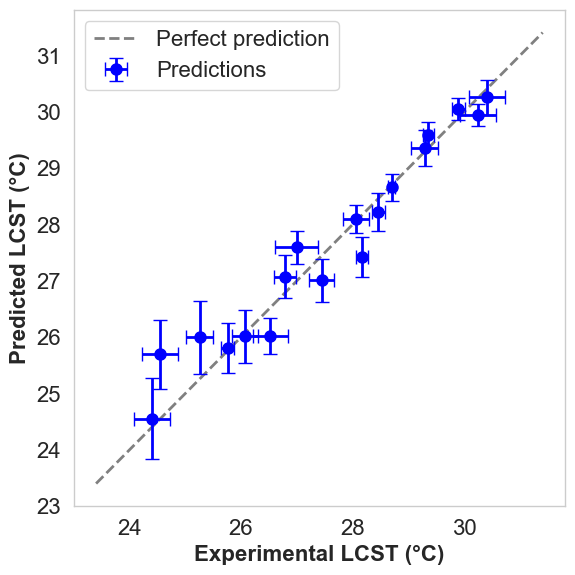


Model Performance:
R² Score: 0.941
Mean Absolute Error: 0.33 °C
Root Mean Squared Error: 0.45 °C

Optimized Kernel Parameters: 3.6**2 * Matern(length_scale=[12.3, 16.3], nu=1) + WhiteKernel(noise_level=1.61e-09)

Expected Improvement Method:
NaCl: 0.603 mol/L
NaBr: 0.633 mol/L
Score: 0.0011


/var/folders/t9/0tql25xd5g38fgmb78nsv_ym0000gn/T/ipykernel_34739/214084959.py:264: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 1
  plt.legend(handles=[exp_handle, combined_handles],labels=['Experimental Data'],handler_map={tuple: HandlerTuple(ndivide=None)})


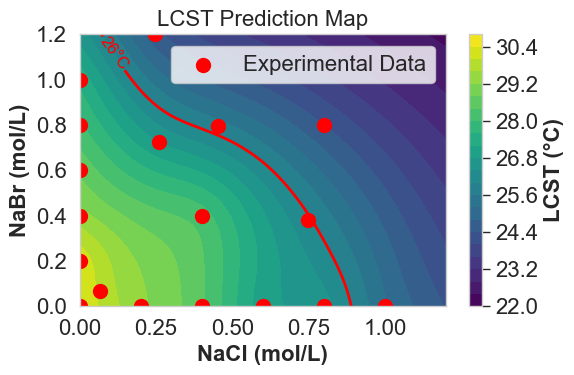

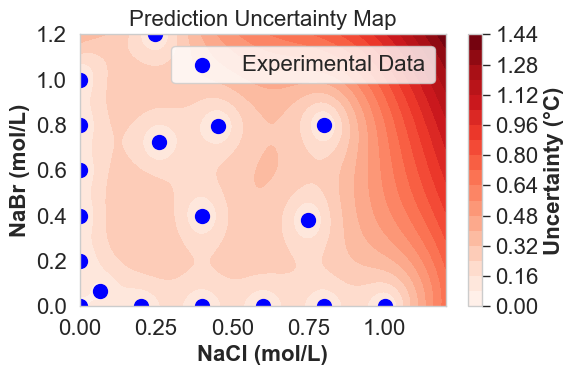

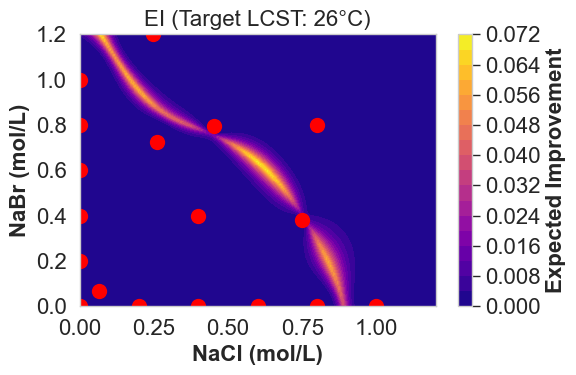

((0.6030150753768844, 0.6331658291457286), 0.0010951194167283518)

In [19]:
predictor = LCSTPredictor()

# Prepare data
X, y, y_std = predictor.prepare_data()

# Create and train model
predictor.create_model()

# Perform leave-one-out cross validation and create parity plot
r2, mae, rmse = predictor.leave_one_out_cv()

# Print model performance
print("\nModel Performance:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.2f} °C")
print(f"Root Mean Squared Error: {rmse:.2f} °C")
print("\nOptimized Kernel Parameters:", predictor.gpr.kernel_)

target_lcst = 26

# Using Expected Improvement
optimal_conc_ei, score_ei = predictor.optimize_concentrations(target_lcst, method='ei')

print("\nExpected Improvement Method:")
print(f"NaCl: {optimal_conc_ei[0]:.3f} mol/L")
print(f"NaBr: {optimal_conc_ei[1]:.3f} mol/L")
print(f"Score: {score_ei:.4f}")

# Visualize the results
predictor.plot_expected_improvement(target_lcst)